$$v(t, x) = 1 + u(t)w(x)$$

$$v(t) = 1 + u(t)w(x(t))$$

We will consider inhibitory weights ($w < 0$).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from disp import set_plot

cc = np.concatenate

RT = np.linspace(-.05, 3.35, 3001)
RX = np.linspace(-.05, 3.35, 3001)

def plot_trj(ax, u_fn, w, t=None, xs=None, cscale=1):
    v_mat = 1 + u_fn(RT)[:, None]@w[None, :]
    ax.matshow(
        cscale*(v_mat.T-1), origin='lower', extent=[RT[0], RT[-1], RX[0], RX[-1]],
        vmin=-1, vmax=1, cmap='PuOr', zorder=0)  # pink = slow, g = fast, 1 = white
    
    if t is not None:
        [ax.plot(t, x, c='k') for x in xs]
    
    ax.xaxis.tick_bottom()
    set_plot(ax, x_label='t', y_label='x')

In [2]:
DT = .001
PER_T = .22
DUTY_T = 1/3
T_0 = .1

PER_X = .2
DUTY_X = .5
X_0 = .12

def u_fn(t_):
    sq_wv = signal.square((2*np.pi*(t_- T_0)/PER_T), duty=DUTY_T)
    return (sq_wv + 1)/2

w = -.5*(signal.square((2*np.pi*(RX - X_0)/PER_X), duty=DUTY_X)+1)/2

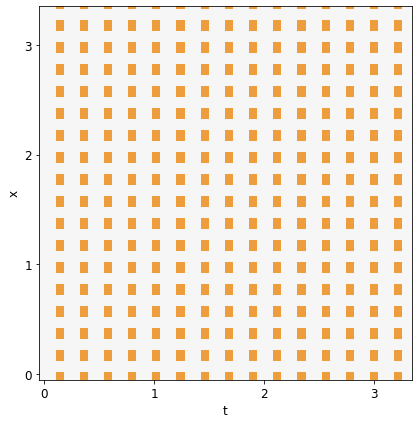

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
plot_trj(ax, u_fn, w)

In [4]:
def w_fn(x_, w):
    idx = np.argmin(np.abs(x_-RX))
    return w[idx]

def v_0_fn(x_, v_0):
    idx = np.argmin(np.abs(x_-RX))
    return v_0[idx]

def smlt(x_0, t, u_fn, w, v_0):
    
    x = np.nan*np.zeros(len(t))
    u = np.nan*np.zeros(len(t))
    v = np.nan*np.zeros(len(t))
    
    x[0] = x_0
    u[0] = u_fn(0)
    v[0] = v_0_fn(x_0, v_0) + u[0]*w_fn(x_0, w)

    for ct, t_ in enumerate(t[1:], 1):
        u[ct] = u_fn(t_)
        v[ct] = v_0_fn(x[ct-1], v_0) + u[ct]*w_fn(x[ct-1], w)
        x[ct] = x[ct-1] + DT*v[ct]
        
    return x, u, v

In [5]:
t = np.arange(0, 3, DT)
x_0 = 0.
v_0s = [
    .96*np.ones(len(RX)),
    1.*np.ones(len(RX)),
    1.04*np.ones(len(RX)),
]

xs_mod = []
us_mod = []
vs_mod = []

for v_0 in v_0s:
    x, u, v = smlt(x_0, t, u_fn, w, v_0)
    xs_mod.append(x.copy())
    us_mod.append(u.copy())
    vs_mod.append(v.copy())
    
xs_unm = []
us_unm = []
vs_unm = []

for v_0 in v_0s:
    x, u, v = smlt(x_0, t, u_fn, 0*w, v_0)
    xs_unm.append(x.copy())
    us_unm.append(u.copy())
    vs_unm.append(v.copy())

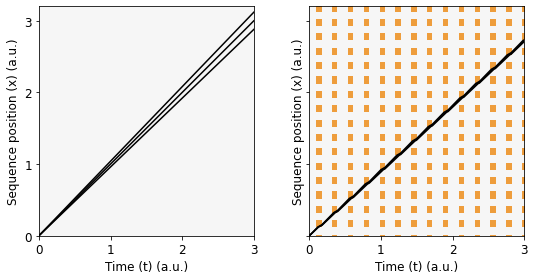

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
plot_trj(axs[0], u_fn, 0*w, t, xs_unm) #, cscale=.25/W_SCALE)
plot_trj(axs[1], u_fn, w, t, xs_mod) #, cscale=.25/W_SCALE)
for ax in axs:
    set_plot(ax, x_lim=(0, 3.), y_lim=(0, 3.2), x_label='Time (t) (a.u.)', y_label='Sequence position (x) (a.u.)')

fig.savefig('ms/2_multi_v_0_correction.svg')

In [7]:
t = np.arange(0, 3, DT)
x_0s = [-.03, 0., .03]
v_0 = np.ones(len(RX))

DUTY_T = 1/3
T_0 = .1

PER_TS = [.185, .2, .215, .23, .245, .26]

xs_all = []

for PER_T in PER_TS:
    
    def u_fn(t_):
        sq_wv = signal.square((2*np.pi*(t_- T_0)/PER_T), duty=DUTY_T)
        return (sq_wv + 1)/2
    
    x, u, v = smlt(x_0, t, u_fn, w, v_0)
    xs = [smlt(x_0, t, u_fn, w, v_0)[0] for x_0 in x_0s]
    xs_all.append(xs)

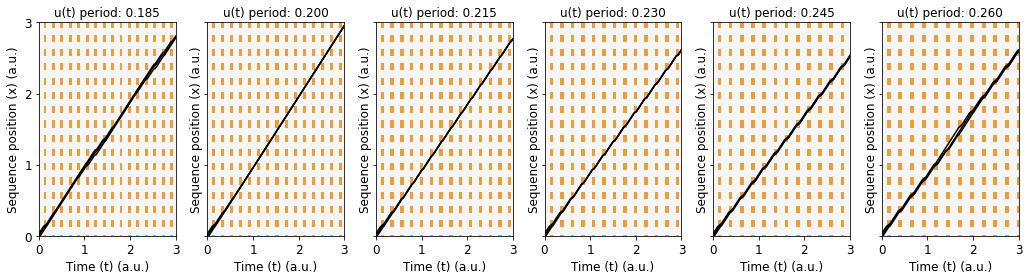

In [8]:
fig, axs = plt.subplots(1, 6, figsize=(12*6/5, 4), tight_layout=True, sharey=True)
for ax, PER_T, xs in zip(axs, PER_TS, xs_all):
    
    def u_fn(t_):
        sq_wv = signal.square((2*np.pi*(t_- T_0)/PER_T), duty=DUTY_T)
        return (sq_wv + 1)/2
    
    plot_trj(ax, u_fn, w, t, xs) #, cscale=.25/W_SCALE)
    ax.set_aspect('auto')
    set_plot(ax, x_lim=(0, 3), y_lim=(0, 3.), x_label='Time (t) (a.u.)', y_label='Sequence position (x) (a.u.)', title=f'u(t) period: {PER_T:.3f}')

fig.savefig('ms/2_multi_speed_control.svg')